In [1]:
import numpy as np
import pandas as pd
import warnings
import os

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.compat.v1.keras.layers import TimeDistributed
warnings.simplefilter('ignore')

countryName = 'US'

nfeatures = 1

nDaysMin = 10
k = 7

nValid = 10
nTest = 10

In [2]:
dataDir = os.path.join('C:\\Users\\AMC\\Desktop\\Roshi\\Data')
confirmedFile = 'confirmed_july.csv'
deathsFile = 'deaths_july.csv'
recoveredFile = 'recovered_july.csv'

In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, k):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix + k >= len(sequence):
            break
        # input and output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+k]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
def meanAbsolutePercentageError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    absPcErrorList = [absError/yTrue for absError, yTrue in zip(absErrorList, yTrueList)]
    MAPE = 100*np.mean(absPcErrorList)
    return MAPE

def meanAbsolutePercentageError_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
            
    # Get MAPE for each day in a list
    MAPEList = []
    for i in yTrueForDayK.keys():
        MAPEList.append(meanAbsolutePercentageError(yTrueForDayK[i], yPredForDayK[i]))
    return np.mean(MAPEList)

def meanForecastError(yTrueList, yPredList):
    forecastErrors = [yTrue - yPred for yTrue, yPred in zip(yTrueList, yPredList)]
    MFE = np.mean(forecastErrors)
    return MFE

def meanAbsoluteError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(absErrorList)

def meanSquaredError(yTrueList, yPredList):
    sqErrorList = [np.square(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(sqErrorList)

def rootMeanSquaredError(yTrueList, yPredList):
    return np.sqrt(meanSquaredError(yTrueList, yPredList))

def medianSymmetricAccuracy(yTrueList, yPredList):
    '''https://helda.helsinki.fi//bitstream/handle/10138/312261/2017SW001669.pdf?sequence=1'''
    logAccRatioList = [np.abs(np.log(yPred/yTrue)) for yTrue, yPred in zip(yTrueList, yPredList)]
    MdSA = 100*(np.exp(np.median(logAccRatioList))-1)
    return MdSA

def medianSymmetricAccuracy_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
    # Get MdSA for each day in a list
    MdSAList = []
    for i in yTrueForDayK.keys():
        MdSAList.append(medianSymmetricAccuracy(yTrueForDayK[i], yPredForDayK[i]))
    return(np.mean(MdSAList))

In [5]:
# All three csvs for this countru
def getCountryDict(countryName):
    countryDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryDict

In [6]:
# get time series data for country
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(confirmedFile)
covidFrDict['deaths'] = pd.read_csv(deathsFile)
covidFrDict['recovered'] = pd.read_csv(recoveredFile)

countryDict = getCountryDict(countryName)

# List of dates
colNamesList = list(countryDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName]
dataList = [countryDict['confirmed'][date].iloc[0] for date in dateList]
dataDict = dict(zip(dateList, dataList))

# Only take time series from where the cases were >100
daysSince = 100
nCasesGreaterDaysSinceList = []
datesGreaterDaysSinceList = []

for key in dataDict.keys():
    if dataDict[key] > daysSince:
        datesGreaterDaysSinceList.append(key)
        nCasesGreaterDaysSinceList.append(dataDict[key])
        
XList, yList = split_sequence(nCasesGreaterDaysSinceList, nDaysMin, k)

XTrainList = XList[0:len(XList)-(nValid + nTest)]
XValidList = XList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
XTestList = XList[-nTest:]

yTrain = yList[0:len(XList)-(nValid + nTest)]
yValid = yList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
yTest = yList[-nTest:]
print('Total size of data points for LSTM:', len(yList))
print('Size of training set:', len(yTrain))
print('Size of validation set:', len(yValid))
print('Size of test set:', len(yTest))
type(yTrain)
XTrainList.shape
yTest
dateList 
covidFrDict['confirmed']
type(countryDict)

Total size of data points for LSTM: 130
Size of training set: 110
Size of validation set: 10
Size of test set: 10


dict

In [7]:
# Convert the list to matrix
XTrain = XTrainList.reshape((XTrainList.shape[0], XTrainList.shape[1], nfeatures))
XValid = XValidList.reshape((XValidList.shape[0], XValidList.shape[1], nfeatures))
XTest = XTestList.reshape((XTestList.shape[0], XTestList.shape[1], nfeatures))

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

neurons = 100 # number of neurones
nfeatures = 1  # number of features

#getting the best MAPE to use for model fitting
bestValidMAPE = 100 #100 validation for selecting the best MAPE
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    
    # define model
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(nDaysMin, nfeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
   
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)
    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed

print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
   

0 0.334764053169715
Updating best MAPE to 0.334764053169715...
Updating best seed to 0...
1 2.4598687668321957
2 149.4521242862511
3 nan
4 0.4227328151111361
5 99.9877531355492
6 99.98798768245784
7 1.8570235663134531
8 1.6235885570222237
9 0.854574526887082
10 3.5870555297302373
11 5.070780397331463
12 1.4776530331030282
13 3.8217119455906294
14 99.98747478024168
15 0.3930474001317446
16 0.9667461588275429
17 0.32794385691744793
Updating best MAPE to 0.32794385691744793...
Updating best seed to 17...
18 1.1276903653724148
19 0.9759995253047525
20 99.9884018871111
21 1.0267471491422047
22 99.99403549727342
23 99.98975177017999
24 99.9878244637872
25 1.4166349139403744
26 99.98871674456237
27 0.4780636903985495
28 99.98815700812453
29 99.99155077721821
30 4.809641256690684
31 99.98861866750677
32 0.9065912760611499
33 99.98827503852009
34 1.408054615042175
35 0.5100638820600997
36 1.3155648884383855
37 9.082354933086865
38 1.5768464895656433
39 0.3367984887800688
40 0.7358922156289903
4

In [9]:
# define model
model = Sequential()
model.add(LSTM(neurons, activation='relu', input_shape=(nDaysMin, nfeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')
model.summary()

history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_100 (LSTM)              (None, 100)               40800     
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


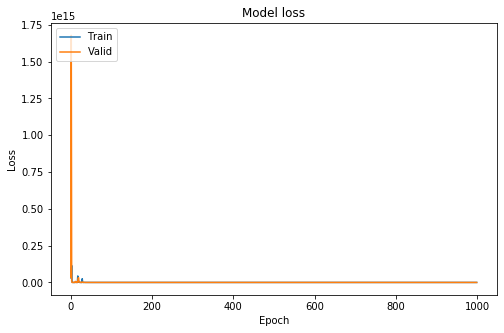

In [10]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [11]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredVanilla = yPredListList 
#Test MAPE: 0.04888603859343367
#Test MdSA: 0.05161317825322761
#Test MSE: 203428.25474330358
#Test RMSE: 451.03021488953885

Test MAPE: 0.6483771438387472
Test MdSA: 0.6457198059949709
Test MSE: 1274224476.9410715
Test RMSE: 35696.2809959395


In [13]:
datesForPlottingList_df = pd.DataFrame(datesForPlottingList)
datesForPlottingList_df
groundTruthList_df = pd.DataFrame(groundTruthList)
groundTruthList_df
yPredVanilla[-1]#[786326.1, 791561.75, 795952.1, 810342.25, 813480.75, 813834.0, 838000.0]

[3913773.2, 3987611.2, 4065455.8, 4143624.8, 4223461.0, 4302944.0, 4384023.0]

In [14]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla)
print('Test RMSE:', RMSE)

Test RMSE: 471521.2870272715


In [15]:
yPredVanilla[-1]
yPredVanilla_df = pd.DataFrame(yPredVanilla[-1])
yPredVanilla_df
#merge the three dataframes?
yPredVanilla_df

,0
0,3913773.25
1,3987611.25
2,4065455.75
3,4143624.75
4,4223461.00
5,4302944.00
6,4384023.00


In [16]:
dates = datesForPlottingList_df
actual = groundTruthList_df
predicted_vanilla = yPredVanilla_df
datesForPlottingList
groundTruthList #[787890, 793720, 799499, 805332, 811073, 816680, 822060]

[3970121, 4038816, 4112531, 4178970, 4233923, 4290337, 4351997]

# Stacked LSTM

In [17]:
neurons = 50
nfeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nfeatures)))
    model.add(LSTM(neurons, activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)
        
        
#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)

    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
        
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nfeatures)))
model.add(LSTM(neurons, activation='relu'))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 65.3450176193644
Updating best MAPE to 65.3450176193644...
Updating best seed to 0...
1 99.99565257719986
2 5.09999706128057
Updating best MAPE to 5.09999706128057...
Updating best seed to 2...
3 63.538188079520474
4 nan
5 57.00218058508775
6 65.4933888687063
7 99.98860291982747
8 nan
9 63.5819799315231
10 99.98795196687266
11 1.0283655221779386
Updating best MAPE to 1.0283655221779386...
Updating best seed to 11...
12 1.7227020356089204
13 0.9083274545725228
Updating best MAPE to 0.9083274545725228...
Updating best seed to 13...
14 99.99057893070344
15 1.5359259297945598
16 266.59812342451085
17 99.98792755151217
18 2.4985330782298276
19 99.98895566026975
20 55.723709086690356
21 346.15177707146756
22 5.701733879345633
23 94.8890626418691
24 55.55227253764243
25 318.423636054074
26 108.82259024453124
27 0.8399304605223851
Updating best MAPE to 0.8399304605223851...
Updating best seed to 27...
28 62.160940300229925
29 64.125698929594
30 nan
31 61.58383051218974
32 2.6484983603294814


In [18]:
model.summary()

Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_301 (LSTM)              (None, 10, 50)            10400     
_________________________________________________________________
lstm_302 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


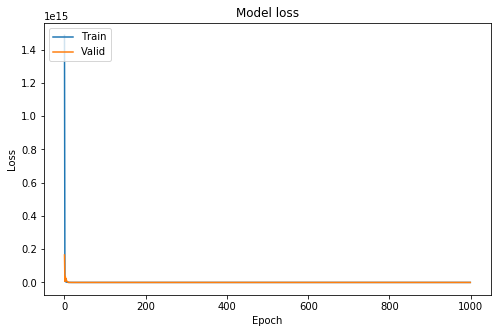

In [19]:
#diagnostic plots
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [20]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredStacked = yPredListList
#Test MAPE: 0.6526826190135445
#Test MdSA: 0.6277125989801505
#Test MSE: 37158961.193359375
#Test RMSE: 6095.815055704969

Test MAPE: 1.4835551933629454
Test MdSA: 1.46124789482622
Test MSE: 5095610146.275893
Test RMSE: 71383.54254501448


In [22]:
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked)
print('Test RMSE:', RMSE)

Test RMSE: 446800.59853170754


# Bi-directional LSTM

In [23]:
# define model
neurons = 50
nfeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu'), input_shape=(nDaysMin, nfeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(Bidirectional(LSTM(neurons, activation='relu'), input_shape=(nDaysMin, nfeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 3.839415456453154
Updating best MAPE to 3.839415456453154...
Updating best seed to 0...
1 3.8578417814235104
2 99.98752106387239
3 99.98993082198321
4 1.2432108028486655
Updating best MAPE to 1.2432108028486655...
Updating best seed to 4...
5 1.3537239086395925
6 0.4739353034217356
Updating best MAPE to 0.4739353034217356...
Updating best seed to 6...
7 1.7701468920511079
8 99.9878105572376
9 0.8790779500709264
10 1.3586454375510815
11 2.741600819688179
12 1.5850007762274463
13 99.98796213678358
14 1.5185736178675633
15 2.147572856866943
16 1.0334063977175423
17 1.384108649656398
18 0.7093339614754084
19 99.98832645323158
20 99.990296414404
21 11.216321088447858
22 2.0855771013513396
23 0.8650688357068422
24 3.68662589340366
25 0.6685034348956993
26 0.28811497046717716
Updating best MAPE to 0.28811497046717716...
Updating best seed to 26...
27 0.3249421066425074
28 99.98777001160018
29 106.83089621237364
30 1.3171000374756836
31 4.170211103105763
32 99.9881849191167
33 1.828129982618

In [24]:
model.summary()

Model: "sequential_302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_100 (Bidirecti (None, 100)               20800     
_________________________________________________________________
dense_302 (Dense)            (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


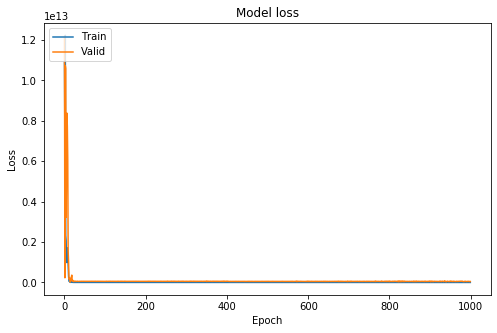

In [25]:
#diagnostic plots
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [26]:
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=30, verbose=1)

Epoch 1/30
4/4 [==============================] - 0s 29ms/step - loss: 382639744.0000 - val_loss: 48222711808.0000
Epoch 2/30
4/4 [==============================] - 0s 29ms/step - loss: 401508736.0000 - val_loss: 47053090816.0000
Epoch 3/30
4/4 [==============================] - 0s 29ms/step - loss: 347717600.0000 - val_loss: 50316914688.0000
Epoch 4/30
4/4 [==============================] - 0s 29ms/step - loss: 324468768.0000 - val_loss: 56866996224.0000
Epoch 5/30
4/4 [==============================] - 0s 30ms/step - loss: 343081376.0000 - val_loss: 54291136512.0000
Epoch 6/30
4/4 [==============================] - 0s 28ms/step - loss: 332130304.0000 - val_loss: 51331538944.0000
Epoch 7/30
4/4 [==============================] - 0s 29ms/step - loss: 350539616.0000 - val_loss: 48030134272.0000
Epoch 8/30
4/4 [==============================] - 0s 27ms/step - loss: 398011648.0000 - val_loss: 54458097664.0000
Epoch 9/30
4/4 [==============================] - 0s 30ms/step - loss: 364769120

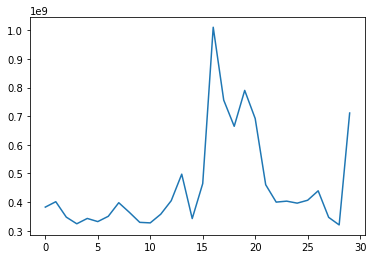

In [27]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.show()

In [28]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredBidirectional = yPredListList
#Test MAPE: 5.3922052299956595
#Test MdSA: 5.396834387761436
#Test MSE: 56670526632.16428
#Test RMSE: 238055.72169591783

Test MAPE: 5.3922052299956595
Test MdSA: 5.396834387761436
Test MSE: 56670526632.16428
Test RMSE: 238055.72169591783


In [30]:
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional)
print('Test RMSE:', RMSE)

Test RMSE: 357907.80456859415


In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Format y tick labels
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

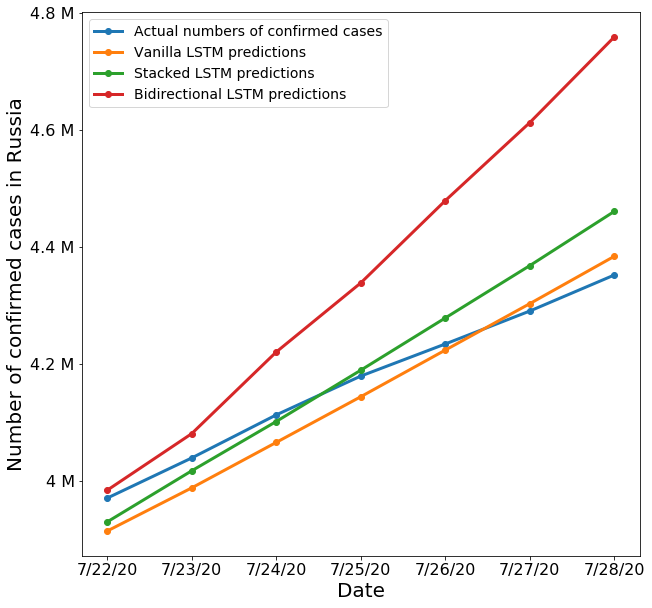

In [32]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in US', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
plt.savefig(os.path.join('Plots_3days_k7_new', 'predictions_{}.png'.format(countryName)), dpi=400)
plt.savefig(os.path.join('Plots_3days_k7_new', 'predictions_{}.pdf'.format(countryName)), dpi=400)

In [33]:
datesForPlottingList
groundTruthList
#yPredVanilla[-1]
#yPredStacked[-1]
#yPredBidirectional[-1]

[3970121, 4038816, 4112531, 4178970, 4233923, 4290337, 4351997]

In [35]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla)
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked)
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional)
print('Test RMSE:', RMSE)

#Test RMSE: 471521.2870272715
#Test RMSE: 446800.59853170754
#Test RMSE: 357907.80456859415

Test RMSE: 471521.2870272715
Test RMSE: 446800.59853170754
Test RMSE: 357907.80456859415


In [39]:
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredVanilla )

In [40]:
MAPE

0.6483771438387472

In [41]:
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredStacked )

In [42]:
MAPE

1.4835551933629454

In [43]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional[-1])
print('Test RMSE:', RMSE)
#Test RMSE: 38833.74045070674
#Test RMSE: 56367.72730583521
#Test RMSE: 229591.4375799083

Test RMSE: 38833.74045070674
Test RMSE: 56367.72730583521
Test RMSE: 229591.4375799083


In [44]:
groundTruthList
#[3970121, 4038816, 4112531, 4178970, 4233923, 4290337, 4351997]

[3970121, 4038816, 4112531, 4178970, 4233923, 4290337, 4351997]

In [45]:
 yPredVanilla[-1]
##[3913773.2, 3987611.2, 4065455.8, 4143624.8, 4223461.0, 4302944.0, 4384023.0]

[3913773.2, 3987611.2, 4065455.8, 4143624.8, 4223461.0, 4302944.0, 4384023.0]

In [46]:
yPredStacked[-1]
#[3929361.8, 4016824.0, 4101229.8, 4189010.0, 4278433.5, 4368046.0, 4460845.0]

[3929361.8, 4016824.0, 4101229.8, 4189010.0, 4278433.5, 4368046.0, 4460845.0]

In [47]:
yPredBidirectional[-1]
#[3983544.0, 4080385.2, 4220094.0, 4338333.0, 4479160.5, 4612810.5, 4759404.0]

[3983544.0, 4080385.2, 4220094.0, 4338333.0, 4479160.5, 4612810.5, 4759404.0]